# **Project 4 - Q Learning**

For this project, you will be tasked with both implementing and explaining key components of the Q-learning algorithm.

All the code deliverables has to be provided within this notebook.

# 1 - Packages
Let's first import all the packages that you will need during this assignment.

* 
[numpy](https://numpy.org/) - is the main package for scientific computing with Python
*
[matplotlib](https://matplotlib.org/) - is a plotting library
*
[gym](https://gym.openai.com/docs/) - Gym is a toolkit for developing and comparing reinforcement learning algorithms.
*
[gym.spaces](http://gym.openai.com/docs/) - Every environment comes with an action_space and an observation_space. These attributes are of type Space, and they describe the format of valid actions and observations.
*
[time](https://docs.python.org/3/library/time.html?highlight=time#module-time) - will be used to track how much time each computation takes
*
[copy](https://docs.python.org/3/library/copy.html) - A copy is sometimes needed so one can change one copy without changing the other.
*
[Threading](https://docs.python.org/3/library/threading.html) - This module constructs higher-level threading interfaces on top of the lower level thread module.
*
[Collections](https://docs.python.org/2/library/collections.html) - This module implements specialized container datatypes providing alternatives to Python’s general purpose built-in containers, dict, list, set, and tuple.


In [0]:

import numpy as np
import matplotlib.pyplot as plt
import gym
import gym.spaces
import time
import copy
import threading
import time
import collections

`## Basic Environment
Here we define our grid-world environment. No need to make any changes.

In [0]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': ['human'] }
    
    def __init__(self, normalize=False, size=4):
        self.observation_space = gym.spaces.Box(0, size, (size,))
        self.action_space = gym.spaces.Discrete(4)
        self.max_timesteps = size*2 + 1
        self.normalize = normalize
        self.size = size

        # Generate State Transition Table
        self.transition_matrix = []
        for x in range(size + 1):
            state_x = []
            for y in range(size + 1):
                state_y = []
                for a in range(4):
                    one_hot = np.zeros(4)
                    one_hot[a] = 1
                    state_y.append(one_hot)
                state_x.append(state_y)
            self.transition_matrix.append(state_x)
        
    def transition_func(self, x, y, action, return_probs=False):
        probs = self.transition_matrix[x][y][action]
        if return_probs:
            return probs
        else:
            return np.random.choice(len(probs), p=probs)

    def _get_distance(self, x, y):
        return abs(x[0] - y[0]) + abs(x[1] - y[1])
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [self.size, self.size]
        self.state = np.zeros((self.size + 1, self.size + 1))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.prev_distance = self._get_distance(self.agent_pos, self.goal_pos)
        return np.array(self.agent_pos)/1.
    
    def step(self, action):
        action_taken = self.transition_func(self.agent_pos[0], self.agent_pos[1], action)
        self.state = np.random.choice(self.observation_space.shape[0])
        if action_taken == 0:
            self.agent_pos[0] += 1
        if action_taken == 1:
            self.agent_pos[0] -= 1
        if action_taken == 2:
            self.agent_pos[1] += 1
        if action_taken == 3:
            self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, self.size)
        self.state = np.zeros((self.size + 1, self.size + 1))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        
        current_distance = self._get_distance(self.agent_pos, self.goal_pos)
        if current_distance < self.prev_distance:
            reward = 1
        elif current_distance > self.prev_distance:
            reward = -1
        else:
            reward = -1
        self.prev_distance = current_distance
        
        self.timestep += 1
        if self.timestep >= self.max_timesteps or current_distance == 0:
            done = True
        else:
            done = False
        info = {}
        
        obs = self.agent_pos
        if self.normalize:
            obs = obs/self.size
        return obs, reward, done, info
        
    def render(self, mode='human'):
        plt.imshow(self.state)

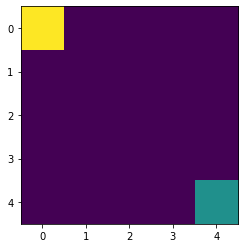

In [0]:
env = GridEnvironment()
obs = env.reset()
env.render()

## Random Agent
This runs the environment with a random agent that just takes random actions. Neither does he learn, nor remember anything. Try to run it!

In [0]:
class RandomAgent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def policy(self, observation):
        return np.random.choice(self.action_space.n)
        
    def step(self, observation, verbose=False):
        return self.policy(observation)

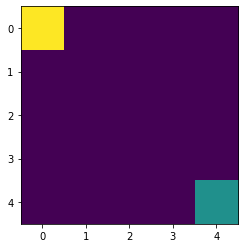

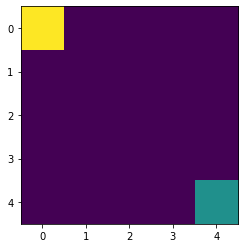

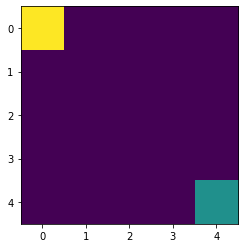

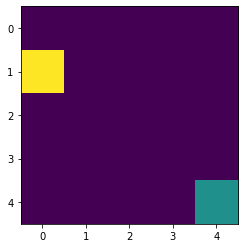

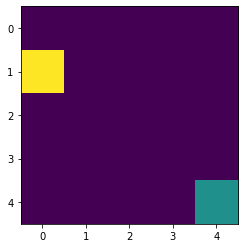

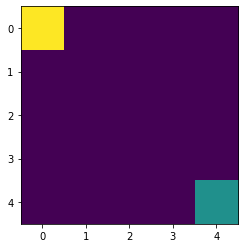

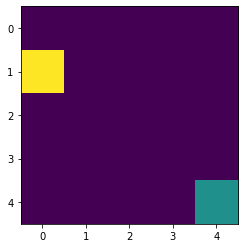

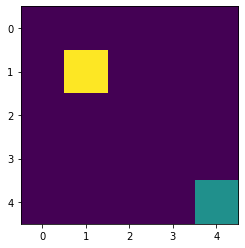

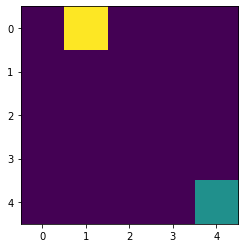

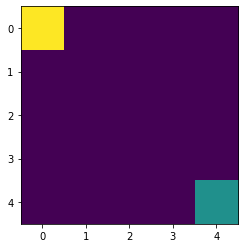

In [0]:
env = GridEnvironment(normalize=True)
agent = RandomAgent(env)

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs, verbose=True)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

## Heuristic Agent
This runs the environment with a heuristic agent. No need to make any changes. Try to run it!

In [0]:
class HeuristicAgent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def policy(self, observation):
        # 0 - down
        # 1 - up
        # 2 - right
        # 3 - left
        if (observation[0] < 1.):
            return 0
        if (observation[1] < 1.):
            return 2
        return 0
        
    def step(self, observation, verbose=False):
        if verbose:
            print(observation)
        return self.policy(observation)

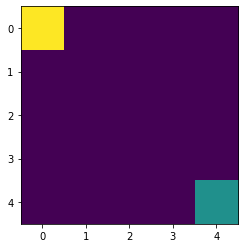

[0. 0.]


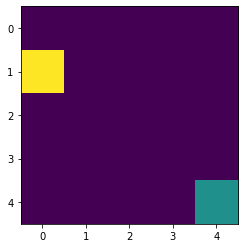

[0.25 0.  ]


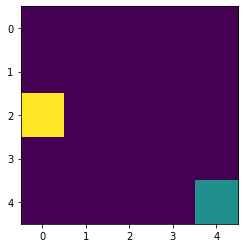

[0.5 0. ]


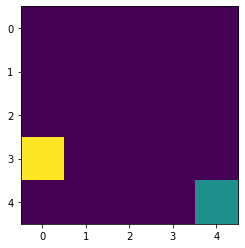

[0.75 0.  ]


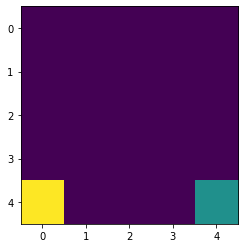

[1. 0.]


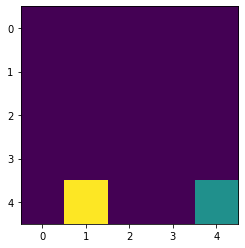

[1.   0.25]


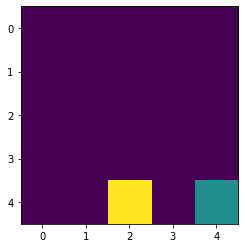

[1.  0.5]


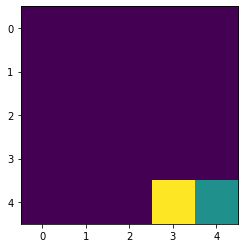

[1.   0.75]


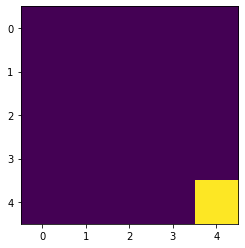

In [0]:
env = GridEnvironment(normalize=True)
agent = HeuristicAgent(env)

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs, verbose=True)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

In [0]:
class QLearningAgent:
    def __init__(self, env, epsilon=1.0, lr=0.1, gamma=0.9):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        q_table_dim = env.observation_space.shape[0] + 1
        self.q_table = np.zeros((q_table_dim, q_table_dim, env.action_space.n))
        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma

    def policy(self, observation):
      # Code for policy (Task 1) (30 points)
      observation = observation.astype(int)
      if np.random.uniform(0, 1) < self.epsilon:
        action = self.action_space.sample()
      else:
        action = np.argmax(self.q_table[observation[0], observation[1]])
      #print(action)
      return action
        
    def step(self, observation):
      #print (observation)
      return self.policy(observation)
        
    def update(self, state, action, reward, next_state):
        state = state.astype(int)
        next_state = next_state.astype(int)
        old_value = self.q_table[state[0], state[1], action]
        next_max = np.max(self.q_table[next_state[0], next_state[1]])
        new_value = (1 - self.lr) * old_value + self.lr * (reward + self.gamma * next_max)
        self.q_table[state[0], state[1], action] = new_value
        
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

In [0]:
env = GridEnvironment() 
agent = QLearningAgent(env)
episodes = 1000 
decay = 0.01
delta_epsilon = agent.epsilon * decay
total_rewards = []
epsilons = [agent.epsilon]
for i in range (episodes):
    state = env.reset()
    done = False
    current_rewards = 0
    while not done:
      #Step
      action = agent.step(state)
      next_state, reward, done, _ = env.step(action)
      print('State:', state, 'Next_State:', next_state)

      #Update
      agent.update(state, action, reward, next_state)
      current_rewards+=reward
      state = next_state.copy()

    total_rewards.append(current_rewards)
    tmp = np.exp(-1 * delta_epsilon * i)
    epsilons.append(tmp)
    agent.set_epsilon(tmp)
  


State: [0. 0.] Next_State: [1 0]
State: [1 0] Next_State: [1 1]
State: [1 1] Next_State: [0 1]
State: [0 1] Next_State: [0 2]
State: [0 2] Next_State: [0 2]
State: [0 2] Next_State: [0 3]
State: [0 3] Next_State: [0 3]
State: [0 3] Next_State: [1 3]
State: [1 3] Next_State: [1 4]
State: [0. 0.] Next_State: [0 0]
State: [0 0] Next_State: [0 1]
State: [0 1] Next_State: [0 2]
State: [0 2] Next_State: [0 1]
State: [0 1] Next_State: [0 0]
State: [0 0] Next_State: [0 0]
State: [0 0] Next_State: [0 1]
State: [0 1] Next_State: [0 1]
State: [0 1] Next_State: [0 1]
State: [0. 0.] Next_State: [1 0]
State: [1 0] Next_State: [2 0]
State: [2 0] Next_State: [1 0]
State: [1 0] Next_State: [1 0]
State: [1 0] Next_State: [0 0]
State: [0 0] Next_State: [0 0]
State: [0 0] Next_State: [0 1]
State: [0 1] Next_State: [0 2]
State: [0 2] Next_State: [0 3]
State: [0. 0.] Next_State: [0 0]
State: [0 0] Next_State: [0 0]
State: [0 0] Next_State: [1 0]
State: [1 0] Next_State: [1 0]
State: [1 0] Next_State: [1 0]


#### Visualize $\epsilon$
Plot our value of $\epsilon$ over each episode

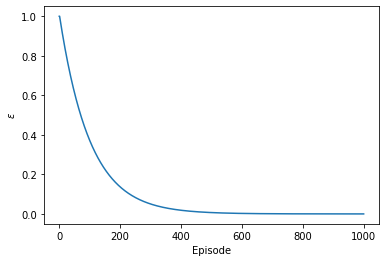

In [0]:
plt.xlabel('Episode')
plt.ylabel('$\epsilon$')
plt.plot(epsilons)

#### Visualize Rewards
Plot total_rewards per episode.  We apply a rolling mean of window $10$ to visualize easier.

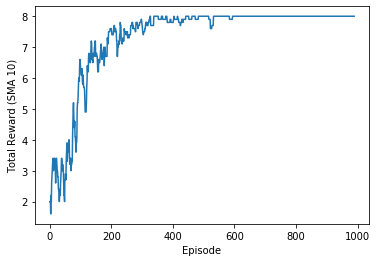

In [0]:
window = 10
plt.xlabel('Episode')
plt.ylabel('Total Reward (SMA 10)')
plt.plot([np.mean(total_rewards[tr:tr+window]) for tr in range(window, len(total_rewards))])

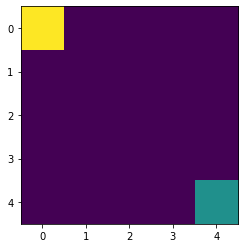

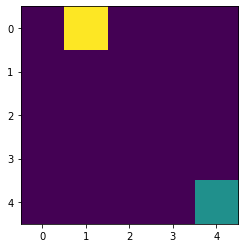

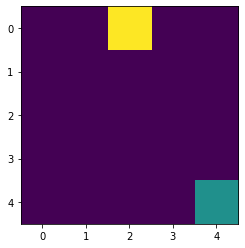

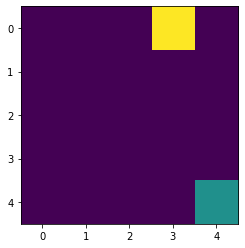

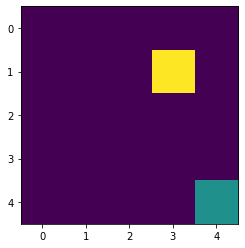

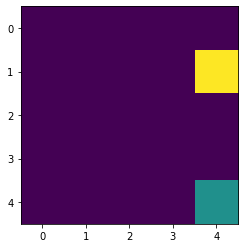

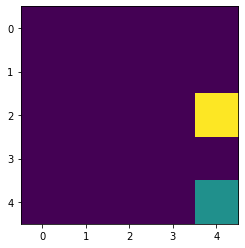

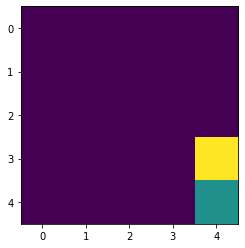

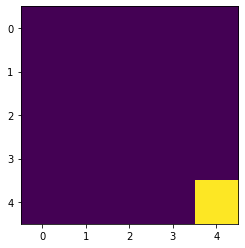

In [0]:
env = GridEnvironment()

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()